# Laboratorium 4

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection([]))

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


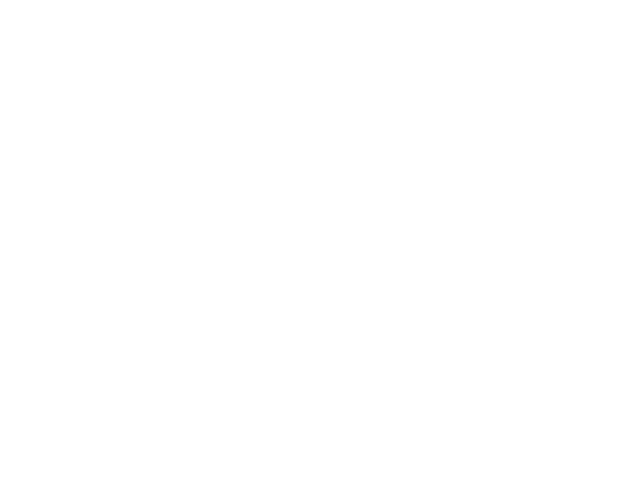

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


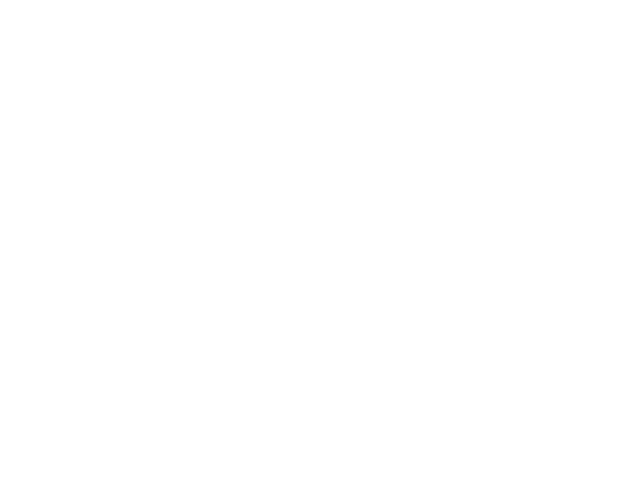

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


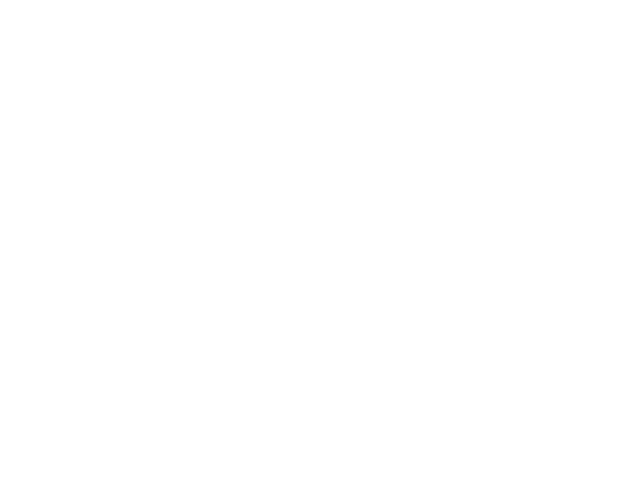

In [5]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


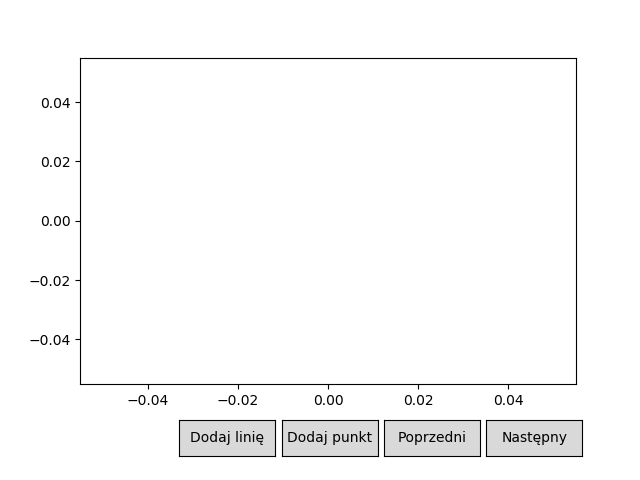

In [6]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

In [28]:
%matplotlib notebook

<IPython.core.display.Javascript object>


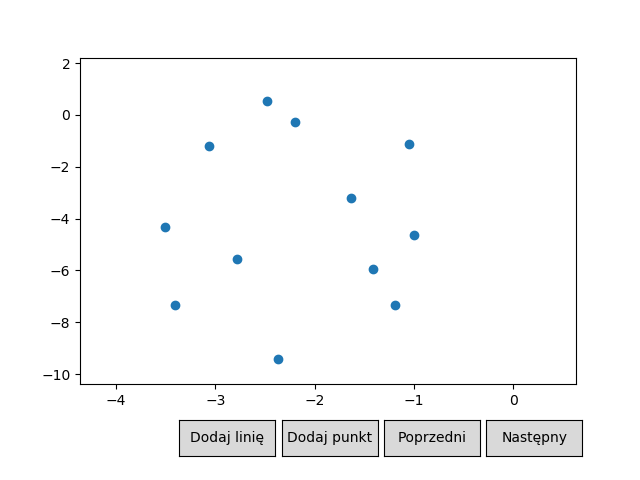

In [44]:
plot_input = Plot()
plot_input.draw()

In [45]:
import random
import math
from enum import Enum

class P_Type(Enum):
    POCZATKOWY = 1
    KONCOWY = 2
    LACZACY = 3
    DZIELACY = 4
    PRAWIDLOWY = 5
    UNDEFINED = 6


class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.type = P_Type.UNDEFINED
    
    def set_type(self, p_type):
        self.type = p_type
    
    def get_x_y_as_tuple(self):
        return (self.x, self.y)
    
    def print_p(self):
        print('('+ "%.2f" % self.x + ',' + "%.2f" % self.y + ') - ', self.type)
    

def get_points_as_tuple_list(points):
    ptl = []
    for p in points:
        ptl.append(p.get_x_y_as_tuple())
    return ptl

def get_points_of_type_as_tuple_list(points, p_type):
    ptl = []
    for p in points:
        if (p.type == p_type): ptl.append(p.get_x_y_as_tuple())
    return ptl

In [46]:
points = []
lines = []

drawed_points = []
for i in plot_input.get_added_points():
    drawed_points.append(i.points)

for i in drawed_points:
    for j in i:
        points.append(Point(j[0], j[1]))
        
for i in range(len(points)):
    lines.append([points[i-1].get_x_y_as_tuple(), points[i].get_x_y_as_tuple()])

In [47]:
# check if y-monotonic

def get_min_and_max_y_idxs(points):
    max_idx = 0
    min_idx = 0
    for i in range(len(points)):
        if points[max_idx].y < points[i].y:
            max_idx = i
        if points[min_idx].y > points[i].y:
            min_idx = i
    return (min_idx, max_idx)


def is_y_mon(points):
    min_y_idx, max_y_idx = get_min_and_max_y_idxs(points)
    
    # right
    current_idx = max_y_idx
    while current_idx != min_y_idx:
        current_idx += 1
        if current_idx == len(points): current_idx = 0
        if points[current_idx].y > points[current_idx-1].y:
            tmp_p = points[current_idx]
            print('Polygon is not y-monotonic')
            print('('+ "%.2f" % tmp_p.x + ',' + "%.2f" % tmp_p.y + ') is a point that spoils y-monoticity')
            return False

    #left
    current_idx = max_y_idx
    while current_idx != min_y_idx:
        current_idx -= 1
        if current_idx == -1: current_idx = (len(points) - 1)
        if points[current_idx].y > points[(current_idx+1) % len(points)].y:
            tmp_p = points[current_idx]
            print('Polygon is not y-monotonic')
            print('('+ "%.2f" % tmp_p.x + ',' + "%.2f" % tmp_p.y + ') is a point that spoils y-monoticity')
            return False
        
    print('Polygon is y-monotonic')
    return True

is_y_mon(points)

Polygon is y-monotonic


True

In [48]:
# set points types

def get_angle(v1, v2):
    dot = v1[0]*v2[0] + v1[1]*v2[1]      # dot product between p1 and p2
    det = v1[0]*v2[1] - v1[1]*v2[0]      # determinant
    return math.atan2(det, dot)  # atan2(y, x) or atan2(sin, cos)


for i in range(len(points)):
    p1 = points[i-1]
    p2 = points[i]
    p3 = points[(i+1) % len(points)]
    
    if p1.y > p2.y and p3.y > p2.y: # trzeba dograć liczenie kata
        angle = get_angle((p3.x-p2.x, p3.y-p2.y), (p1.x-p2.x, p1.y-p2.y))
        if angle > 0:
            p2.set_type(P_Type.KONCOWY)
        else:
            p2.set_type(P_Type.LACZACY)
    
    elif p1.y < p2.y and p3.y < p2.y:
        angle = get_angle((p3.x-p2.x, p3.y-p2.y), (p1.x-p2.x, p1.y-p2.y))
        if angle > 0:
            p2.set_type(P_Type.POCZATKOWY)
        else:
            p2.set_type(P_Type.DZIELACY)

    else: p2.set_type(P_Type.PRAWIDLOWY)
    
for p in points:
    p.print_p()

(-2.48,0.53) -  P_Type.POCZATKOWY
(-3.07,-1.21) -  P_Type.PRAWIDLOWY
(-3.51,-4.33) -  P_Type.PRAWIDLOWY
(-2.78,-5.57) -  P_Type.PRAWIDLOWY
(-3.41,-7.34) -  P_Type.PRAWIDLOWY
(-2.37,-9.43) -  P_Type.KONCOWY
(-1.19,-7.34) -  P_Type.PRAWIDLOWY
(-1.41,-5.95) -  P_Type.PRAWIDLOWY
(-1.00,-4.64) -  P_Type.PRAWIDLOWY
(-1.63,-3.21) -  P_Type.PRAWIDLOWY
(-1.05,-1.13) -  P_Type.PRAWIDLOWY
(-2.20,-0.28) -  P_Type.PRAWIDLOWY


<IPython.core.display.Javascript object>


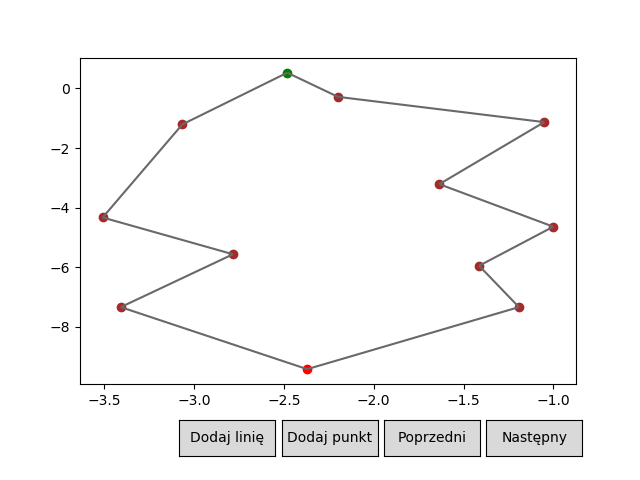

In [49]:
p_t_poczatkowy = get_points_of_type_as_tuple_list(points, P_Type.POCZATKOWY)
p_t_koncowy = get_points_of_type_as_tuple_list(points, P_Type.KONCOWY)
p_t_laczacy = get_points_of_type_as_tuple_list(points, P_Type.LACZACY)
p_t_dzielacy = get_points_of_type_as_tuple_list(points, P_Type.DZIELACY)
p_t_prawidlowy = get_points_of_type_as_tuple_list(points, P_Type.PRAWIDLOWY)


scenes = [Scene(
    [
        PointsCollection(p_t_poczatkowy, color='green'),
        PointsCollection(p_t_koncowy, color='red'),
        PointsCollection(p_t_laczacy, color='blue'),
        PointsCollection(p_t_dzielacy, color='lightblue'),
        PointsCollection(p_t_prawidlowy, color='brown'),
    ], 
    [LinesCollection(lines, color='dimgray')]
)]

plot = Plot(scenes)
plot.draw() 